Modelo de previsão auto regressivo
=

O modelo de previsão auto regressivo utiliza o histórico do sinal de geração para determinar a geração futura.

$$ \hat{P}_{t+1} = B_{0} + P_{t}B_{1} + P_{t-1}B_{2} + ... + P_{t-l}B_{N} $$
$$ \hat{P}_{t+2} = B_{0} + P_{t}B_{3} + P_{t-1}B_{4} + ... + P_{t-l}B_{N+1} $$
$$ \hat{P}_{t+3} = B_{0} + P_{t}B_{5} + P_{t-1}B_{6} + ... + P_{t-l}B_{N+2} $$
$$ \hat{P}_{t+H} = B_{0} + P_{t}B_{H} + P_{t-1}B_{H+1} + ... + P_{t-l}B_{N+H} $$

onde $\hat{P}_{t+H}$ é a previsão de potência no horizonte temporal $H$, $P_{t-N}$ é a potência com atraso $l$ e $B_{N+H}$ é a constante de otimização atrelada ao atraso $l$ para o horizonte temporal $H$. Ou, de outra forma:

$$ \hat{\textbf{P}}_{t+1} = \textbf{B} \textbf{P}_{t-l} $$

onde $\hat{\textbf{P}}_{t+1}$ é o vetor de previsão de potência, $\textbf{B}$ é o vetor com as constantes de otimização e $\textbf{P}$ é o vetor com as potências com atraso.

Obtenção das constantes de otimização
=

Para determinar as constantes de otimização, realiza-se a minimização da função de erro quadrático médio:

$$ F(B) = \frac{1}{N} \sum_{1}^{N} (\hat{\textbf{P}} - \textbf{B}\textbf{P}_{t-l})^2 $$

A determinação do vetor de constantes que minimizam o erro quadrático médio pode ser feita utilizando o método analítico de minimização quadrática:

$$ \textbf{B} = (\textbf{P}_{t-l}^T \times \textbf{P}_{t-l})^{-1} \times \textbf{P}_{t-l}^T \times \textbf{P}_{t+H} $$

Avaliação da performance
=

Existem diversas ferramentas estatísticas para avaliar a performance do modelo. Aqui, será utilizada a raiz do erro quadrático médio ou root mean squared error (RMSE).

$$ RMSE = \sqrt{\frac{1}{N}\sum_{t=1}^{t=N} (P_{t} - \hat{P}_{t})^2 } $$

onde $N$ é a quantidade de valores medidos, $P_{t}$ são as medições de potência no momento $t$, e $\hat{P}_{t}$ são as previsões de potência para o momento $t$.

Implementação do modelo de previsão auto regressivo em octave
=

In [1]:
pkg load dataframe

In [2]:
data_path = '12kW_Farmácia_Max_01012020-01012021.csv';
data_dataframe = dataframe(data_path);
#transformando o dataframe em vetor contendo apenas os dados de energia
energy_data = str2double(data_dataframe.array(1:20000,2));

In [3]:
#tornando os dados NaN em 0
# Os dados NaN que aparecem no arquivo aparentam ocorrer apenas em horários em que não há luz do sol.
for i = 1:size(energy_data)(1)
    if isnan(energy_data(i))
        energy_data(i) = 0;
    endif
endfor

In [4]:
horizonte_de_previsao = 1*12; # O intervalo de medição dos dados é de 5 minutos, portanto, 1 hora representa 12 intervalos de medição
variaveis_de_atraso = 2; # Quantidade de variáveis no vetor de potências de atraso; A quantidade de constantes de otimização será 
                         # sempre a quantidade de variáveis de atraso +1

In [5]:
# A função prev_AR retorna um vetor de tamanho nx1 (onde n é o tamanho do vetor data_prev) contendo a previsão para o horizonte de previsão determinado
# O conjunto data_train é utilizado para determinar as constantes de otimização da função de auto-regressão, enquanto que o conjunto data_prev é 
# utilizado para gerar a previsão futura;
function prev = prev_AR(data_train,data_prev,horizonte_de_previsao,atraso_max)
    lag_matrix = ones(size(data_train)(1),1);
    for i = 0:atraso_max
        lag_matrix = [lag_matrix,[zeros(i,1);data_train(1:end-i)]];
    endfor

    B = inv(transpose(lag_matrix)*lag_matrix)*transpose(lag_matrix)*[data_train(horizonte_de_previsao+1:end);zeros(horizonte_de_previsao,1)];

    prev_lag_matrix = ones(size(data_prev)(1),1);
    for i = 0:atraso_max
        prev_lag_matrix = [prev_lag_matrix,[zeros(i,1);data_prev(1:end-i)]];
    endfor

    prev = transpose(transpose(B)*transpose(prev_lag_matrix));
    return;
endfunction

In [20]:
# Realizando a previsão dos últimos x valores de energia;
x = 600;
prev = prev_AR(energy_data(1:end-x),energy_data(end-x:end),horizonte_de_previsao,variaveis_de_atraso);

In [21]:
function RMSE = calc_RMSE(data1,data2)
    N = size(data1)(1);
    er_sqrd = (data1 - data2).^2;
    mse = sum(er_sqrd)/N;
    RMSE = sqrt(mse);
    return;
endfunction

In [22]:
RMSE = calc_RMSE(prev,[energy_data(end-x+horizonte_de_previsao:end);zeros(horizonte_de_previsao,1)])

RMSE = 178.24


Gráficos
=

In [23]:
function plot_prev(real,prev)
    plot(1:size(real)(1),real,"marker",".","markersize",15,"linewidth",1.5,";Potência real;",1:size(prev)(1),prev,"marker",".","markersize",15,"linewidth",1.5,";Potência prevista;");
    xlabel("Intervalos de tempo");
    ylabel("Energia (Wh)");
    title("Gráfico de Potência real x previsão");
endfunction

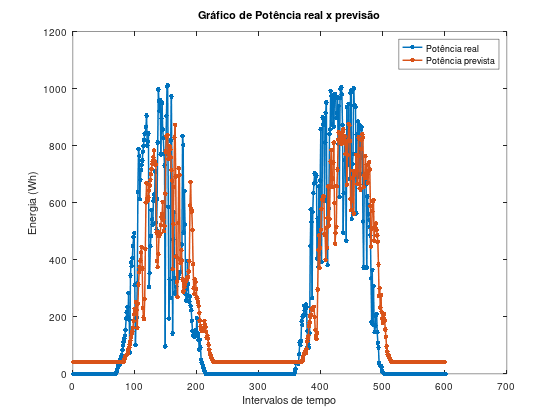

In [24]:
plot_prev([energy_data(end-x+horizonte_de_previsao:end);zeros(horizonte_de_previsao,1)],prev(1:x))

In [26]:
function plot_rmses(RMSEs)
    plot(1:size(RMSEs)(1)+1,RMSEs,"marker",".","linewidth",1.5,"markersize",15,";RMSE;");    
    xlabel("Horizonte temporal");
    ylabel("RMSE (Wh)");
    title("Gráfico de erro");
endfunction

In [27]:
#plot_rmses(RMSEs)

error: 'RMSEs' undefined near line 1, column 12
